# The AR6 Effective Radiative Forcing Timeseries, 1750-2019

In [1]:
import fair
import numpy as np
from fair.constants import molwt
from fair.forcing.ozone_tr import stevenson
from fair.forcing import aerosols
from fair.forcing.bc_snow import linear
from fair.forcing.landuse import cumulative
from fair.forcing.ghg import etminan, meinshausen
from fair.tools.magicc import scen_open
from scipy.interpolate import interp1d
import pandas as pd

import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
forcing = {}
scenario = 'ssp245'  # for where decisions are scenario-dependent

emissions = pd.read_csv('../data/rcmip-emissions-annual-means-v5-1-0.csv')

## Solar radiation
ERF = TSI * 1/4 * 0.71 * 0.72 where 1/4 is geometric factor, 0.71 is planetary co-albedo, 0.72 is rapid adjustment factor

We rebase to the two solar cycles 1745-1765 as our estimate of "pre-industrial". This follows AR5 and is a period of somewhat lower solar activity than 1850-1873 used for CMIP6 pre-industrial.

In [3]:
# get solar forcing from CMIP6 TSI time series
df = pd.read_csv('../data/solar_erf.csv', index_col='year')
forcing['solar'] = np.zeros((270))
forcing['solar'] = df.solar_erf.loc[1750:2019].values

## Volcanic forcing

Use the stratospheric optical depth time series from a combination of Toohey and Sigl (2017; -500 to 1900), CMIP6 (1850-2014), and Glossac (1979-2019). Smoothed overlaps to transition between time series. The zero point is the last-2500 year mean.

ERF = -20 * SAOD based on a combination of CMIP5 models (Larson and Portmann, 2016) and CMIP6 models (my analysis)

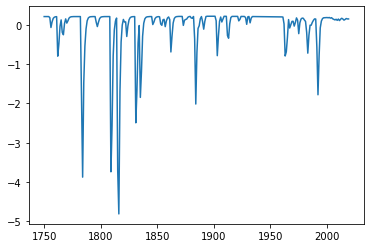

In [4]:
df = pd.read_csv('../data/volcanic_erf.csv', index_col='year')
#forcing['volcanic'] = np.zeros((270))
forcing['volcanic'] = df.volcanic_erf.loc[1750:2019].values
# keep 2014 to 2019 constant
#forcing['volcanic'][265:270] = forcing['volcanic'][264]
pl.plot(np.arange(1750,2020), forcing['volcanic'][:270])

## Aerosol forcing

Use a combination of the model-derived time series from Smith et al. (2020; JGRA; submitted) and the analysis of MERRA2 and CAMS reanalysis from Bellouin et al. (2020; ESSD).

The target forcings are -0.3 W/m2 for ERFari 2005-14 and -1.0 for ERFaci 2005-14.

- 1750 - 1979: Smith et al. only
- 1980 - 2002: mean of Smith et al. and MERRA2
- 2003 - 2014: weighted mean of Smith et al. (0.5), MERRA2 (0.25) and CAMS (0.25)
- 2015 - 2019: mean of MERRA2 and CAMS

**TODO: update this with Nicolas' actual figures rather than my graph-derived ones**

In [5]:
df = pd.read_csv('/nfs/see-fs-02_users/mencsm/my_papers/AR6_aerosols/data/rcmip_total_aerosol_forcing.csv', index_col=0)
smith2020_ari = df.loc[1750:2014, 'ssp245_ERFari'].values
smith2020_aci = df.loc[1750:2014, 'ssp245_ERFaci'].values*1.0/0.9

In [6]:
df = pd.read_csv('/nfs/see-fs-02_users/mencsm/my_papers/AR6_aerosols/data/obs/Bellouin_MERRA2.csv', index_col=0)
merra_ari = df['RFari'].values * (-0.3)/df['RFari'].values[25:35].mean()
merra_aci = df['RFaci'].values * (-1.0)/df['RFaci'].values[25:35].mean()

df = pd.read_csv('/nfs/see-fs-02_users/mencsm/my_papers/AR6_aerosols/data/obs/Bellouin_CAMS.csv', index_col=0)
cams_ari = df['RFari'].values * (-0.3)/df['RFari'].values[2:12].mean()
cams_aci = df['RFaci'].values * (-1.0)/df['RFaci'].values[2:12].mean()

In [7]:
smith2020_ari[230:].shape

(35,)

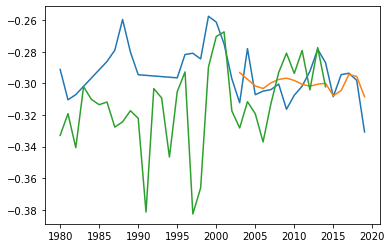

In [8]:
pl.plot(np.arange(1980,2020), merra_ari)
pl.plot(np.arange(2003,2020), cams_ari)
pl.plot(np.arange(1980,2015), smith2020_ari[230:])

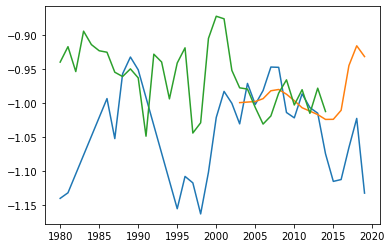

In [9]:
pl.plot(np.arange(1980,2020), merra_aci)
pl.plot(np.arange(2003,2020), cams_aci)
pl.plot(np.arange(1980,2015), smith2020_aci[230:])

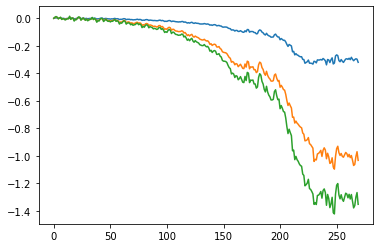

In [10]:
forcing['aerosol-radiation_interactions'] = np.zeros(270)
forcing['aerosol-cloud_interactions'] = np.zeros(270)
forcing['aerosol-radiation_interactions'][:230] = smith2020_ari[:230]
forcing['aerosol-radiation_interactions'][230:253] = np.mean((smith2020_ari[230:253], merra_ari[:23]), axis=0)
forcing['aerosol-radiation_interactions'][253:265] = np.mean((smith2020_ari[253:265], np.mean((merra_ari[23:35], cams_ari[:12]), axis=0)), axis=0)
forcing['aerosol-radiation_interactions'][265:] = np.mean((merra_ari[35:], cams_ari[12:]), axis=0)
forcing['aerosol-cloud_interactions'][:230] = smith2020_aci[:230]
forcing['aerosol-cloud_interactions'][230:253] = np.mean((smith2020_aci[230:253], merra_aci[:23]), axis=0)
forcing['aerosol-cloud_interactions'][253:265] = np.mean((smith2020_aci[253:265], np.mean((merra_aci[23:35], cams_aci[:12]), axis=0)), axis=0)
forcing['aerosol-cloud_interactions'][265:] = np.mean((merra_aci[35:], cams_aci[12:]), axis=0)
pl.plot(forcing['aerosol-radiation_interactions'])
pl.plot(forcing['aerosol-cloud_interactions'])
forcing['aerosol'] = forcing['aerosol-radiation_interactions'] + forcing['aerosol-cloud_interactions']
pl.plot(forcing['aerosol'])

## Contrail forcing

Based on Lee et al 2018 forcing of 0.0574 and scales with aviation NOx emissions. 

**TODO update chapter for 2019 forcing**

In [11]:
df = pd.read_csv('/nfs/a65/pmcjs/input4MIPs/Hosely_etal_2018_supp/Supplemental_Data_Correction/Data Supplement/NOx_CEDS_emissions_by_sector_v2016_07_26.csv')
avi_nox_hist = df[df.sector.str.endswith("aviation")].loc[:,'X1750':'X2014']

0.059369559489030194

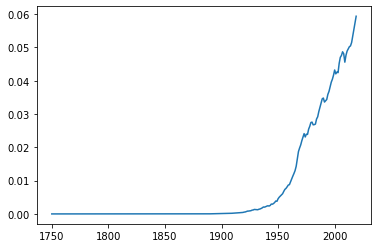

In [12]:
df = pd.read_csv('/nfs/a65/pmcjs/input4MIPs/SSPDb/aviation_nox.csv')
avi_nox = df[(df.Region=="World")&(df.Scenario=='SSP2-45')].loc[:,'2015':'2100']
yearin = pd.to_numeric(avi_nox.columns).values
f = interp1d(yearin, avi_nox)
avi_nox_1750_2019 = np.zeros(270)
avi_nox_1750_2019[265:270] = f(np.arange(2015,2020))
avi_nox_1750_2019[:265] = avi_nox_hist.sum(axis=0)/1000.
contrail_forcing_2018 = 0.0574
forcing['contrails'] = avi_nox_1750_2019/avi_nox_1750_2019[268] * contrail_forcing_2018
pl.plot(np.arange(1750,2020), forcing['contrails'])
forcing['contrails'][-1]

## Land use forcing

Use Ghimire et al. 2014 up to 2005, then FaIR cumulative emissions to 2019, scale to 0.15 W/m2 for 1750 to 2019, and then add --0.05 for irrigation

In [13]:
ghimire = pd.read_csv('../data/ghimire_landuse_raw.csv')
landuse_co2 = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO2|MAGICC AFOLU'),'1750':'2020'].interpolate(axis=1, pad=True).values

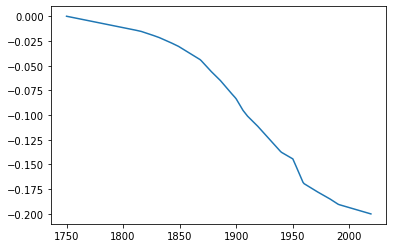

In [14]:
lusf2019 = -0.15/np.cumsum(landuse_co2)  # include irrigation of -0.05 in Sherwood et al
landuse_erf = np.cumsum(landuse_co2)*lusf2019
f = interp1d(ghimire['year'], ghimire['flux'], kind='linear', fill_value='extrapolate', bounds_error=False)
lusf2019 = -0.20/(f(2019)-f(1750))
forcing['land_use'] = lusf2019*(f(np.arange(1750,2020))-f(1750))
pl.plot(np.arange(1750,2020), forcing['land_use'])

## BC on snow

Linear with emissions, 2019 = 0.08

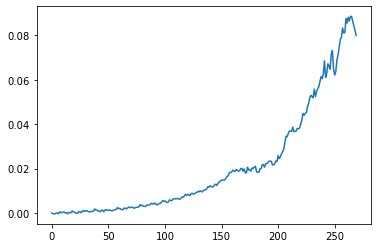

In [15]:
bc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|BC'),'1750':'2020'].interpolate(axis=1, pad=True).values.squeeze()
forcing['bc_on_snow'] = (bc[:270]-bc[0])/(bc[269]-bc[0])*0.08
pl.plot(forcing['bc_on_snow'])

## Greenhouse gas concentrations

**TODO** what are we doing about +5% in non-CO2 gases?

In [16]:
ghg_obs = pd.read_excel('../data/LLGHG_history_AR6_v8a.xlsx', skiprows=22, sheet_name="MR_output", index_col=0)
for addyear in range(1751,1850):
    ghg_obs.loc[addyear, 'YYYY'] = np.nan
ghg_obs = ghg_obs.sort_index()
ghg_obs = ghg_obs.interpolate()
ghg_obs

,CO2,CH4,N2O,HFC-134a,HFC-23,HFC-32,HFC-125,HFC-143a,HFC-152a,HFC-227ea,...,C7F16,C8F18,CFC-112,CFC-112a,CFC-113a,CFC-114a,HCFC-133a,HCFC-31,HCFC-124,YYYY
YYYY,,,,,,,,,,,,,,,,,,,,,
1750,278.70,724.1000,270.0000,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
1751,278.78,724.9350,270.0250,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
1752,278.86,725.7700,270.0500,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
1753,278.94,726.6050,270.0750,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
1754,279.02,727.4400,270.1000,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,399.41,1833.8905,328.3025,83.4145,28.042,9.985158,18.0910,17.5655,6.5970,1.096239,...,0.11,0.0,0.424,0.066,0.62,1.05,0.39897,0.083,1.02,NaN
2016,402.86,1842.0015,329.1240,89.4825,28.950,11.972602,20.4815,19.1555,6.6600,1.205802,...,0.11,0.0,0.416,0.067,0.66,1.04,0.42501,0.083,1.02,NaN
2017,405.00,1849.2615,330.0400,95.7485,29.975,14.153317,23.2450,20.8340,6.8175,1.327504,...,0.11,0.0,0.416,0.067,0.66,1.04,0.43989,0.083,1.02,NaN


In [17]:
gases = ghg_obs.columns.to_list()
gases.remove('YYYY')

In [18]:
# meinshausen/nicholls rcmip set
#conc={}
#gases=['CO2','CH4','N2O',
#     'HFC125','HFC134a','HFC143a','HFC152a','HFC227ea','HFC23','HFC236fa','HFC245fa','HFC32','HFC365mfc','HFC4310mee',
#     'NF3','C2F6','C3F8','C4F10','C5F12','C6F14','C7F16','C8F18','CF4','cC4F8','SF6','SO2F2','CCl4','CFC11','CFC113',
#     'CFC114','CFC115','CFC12','CH2Cl2','CH3Br','CH3CCl3','CH3Cl','CHCl3','HCFC141b','HCFC142b','HCFC22','Halon1211',
#     'Halon1301','Halon2402']

#for gas in gases:
#    conc[gas] = concentrations[(concentrations.Region=="World")&(concentrations.Scenario==scenario)&(concentrations.Variable.str.endswith(gas))].loc[:,'1750':'2019'].squeeze()
#conc[scenario]['CO2'] = df[(df.Region=="World")&(df.Scenario==scenario)&(df.Variable.str.endswith('CO2'))].loc[:,'1750':'2019']
#conc[scenario]['CH4'] = df[(df.Region=="World")&(df.Scenario==scenario)&(df.Variable.str.endswith('CH4'))].loc[:,'1750':'2019']
#conc[scenario]['N2O'] = df[(df.Region=="World")&(df.Scenario==scenario)&(df.Variable.str.endswith('N2O'))].loc[:,'1750':'2019']

In [19]:
forcing['co2'] = np.zeros(270)
forcing['ch4'] = np.zeros(270)
forcing['n2o'] = np.zeros(270)
c = np.array([ghg_obs['CO2'].values, ghg_obs['CH4'].values, ghg_obs['N2O'].values])
for i, year in enumerate(range(1750,2020)):
#    forcing['co2'][i], forcing['ch4'][i], forcing['n2o'][i] = etminan(c[:,i], [ghg_obs.loc[1750,'CO2'], ghg_obs.loc[1750,'CH4'], ghg_obs.loc[1750,'N2O']], scale_F2x=False)
    forcing['co2'][i], forcing['ch4'][i], forcing['n2o'][i] = meinshausen(c[:,i], [ghg_obs.loc[1750,'CO2'], ghg_obs.loc[1750,'CH4'], ghg_obs.loc[1750,'N2O']], scale_F2x=False)

    
# include rapid adjustments for CO2 and CH4 (FOD numbers):
forcing['co2'] = 1.05 * forcing['co2']
forcing['ch4'] = 0.86 * forcing['ch4']

In [20]:
# don't forget to smash Jinho's dashes
radeff = {
    'HFC-125':      0.23378,
    'HFC-134a':     0.16714,
    'HFC-143a':     0.168,
    'HFC-152a':     0.10174,
    'HFC-227ea':    0.27325,
    'HFC-23':       0.19111,
    'HFC-236fa':    0.25069,
    'HFC-245fa':    0.24498,
    'HFC-32':       0.11144,
    'HFC-365mfc':   0.22813,
    'HFC-43-10mee': 0.35731,
    'NF3':          0.20448,
    'C2F6':         0.26105,
    'C3F8':         0.26999,
    'n-C4F10':      0.36874,
    'n-C5F12':      0.4076,
    'n-C6F14':      0.44888,
    'i-C6F14':      0.44888, # not given in Hodnebrog: assume same as n-form
    'C7F16':        0.50312,
    'C8F18':        0.55787,
    'CF4':          0.09859,
    'c-C4F8':       0.31392,
    'SF6':          0.56657,
    'SO2F2':        0.21074,
    'CCl4':         0.16616,
    'CFC-11':       0.25941,
    'CFC-112':      0.28192,  # Etminan et al., 2014 https://core.ac.uk/download/pdf/29111788.pdf
    'CFC-112a':     0.24564,  # Etminan et al., 2014 https://core.ac.uk/download/pdf/29111788.pdf - assume same as 112
    'CFC-113':      0.30142,
    'CFC-113a':     0.24094,  # Etminan et al., 2014
    'CFC-114':      0.31433,
    'CFC-114a':     0.29747, # assume same as 114 - does this make sense?
    'CFC-115':      0.24625,
    'CFC-12':       0.31998,
    'CFC-13':       0.27752,
    'CH2Cl2':       0.02882,
    'CH3Br':        0.00432,
    'CH3CCl3':      0.06454,
    'CH3Cl':        0.00466,
    'CHCl3':        0.07357,
    'HCFC-124':     0.20721,
    'HCFC-133a':    0.14995,
    'HCFC-141b':    0.16065,
    'HCFC-142b':    0.19329,
    'HCFC-22':      0.21385,
    'HCFC-31':      0.068,
    'Halon-1211':   0.30014,
    'Halon-1301':   0.29943,
    'Halon-2402':   0.31169,
}

forcing['other_wmghg'] = np.zeros(270)
for gas in gases[3:]:
    for i,year in enumerate(range(1750,2020)):
        forcing['other_wmghg'][i] = forcing['other_wmghg'][i] + ((ghg_obs.loc[year,gas] - ghg_obs.loc[1750,gas]) * radeff[gas] * 0.001)

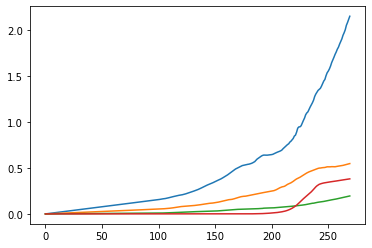

In [21]:
pl.plot(forcing['co2'])
pl.plot(forcing['ch4'])
pl.plot(forcing['n2o'])
pl.plot(forcing['other_wmghg'])

## Tropospheric ozone

Follow Skeie exclusively?

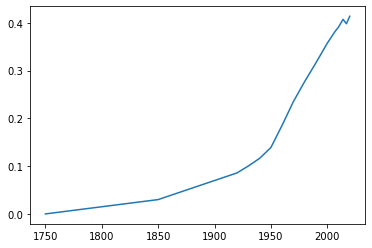

In [22]:
good_models = ['BCC-ESM1', 'CESM2(WACCM6)', 'GFDL-ESM4', 'GISS-E2-1-H', 'MRI-ESM2-0', 'OsloCTM3']
skeie_trop = pd.read_csv('../data/skeie_ozone_trop.csv', index_col=0)
skeie_trop = skeie_trop.loc[good_models]
skeie_trop.insert(0, 1850, 0)
skeie_trop.columns = pd.to_numeric(skeie_trop.columns)
skeie_trop.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
skeie_trop.insert(0, 1750, -0.03)
skeie_trop_post2010 = skeie_trop.loc['OsloCTM3',[2014,2017,2020]]-skeie_trop.loc['OsloCTM3', 2010]
skeie_trop.loc[:,[2014,2017,2020]] = skeie_trop.loc[:,2010:2010].values + skeie_trop_post2010.values[None,:]
skeie_trop = skeie_trop + 0.03
pl.plot(skeie_trop.mean())

In [23]:
f = interp1d(skeie_trop.columns, skeie_trop.mean(), bounds_error=False, fill_value='extrapolate')
years = np.arange(1750,2020)
forcing['o3_trop'] = f(years)

## Stratospheric ozone

Follow Skeie exclusively?

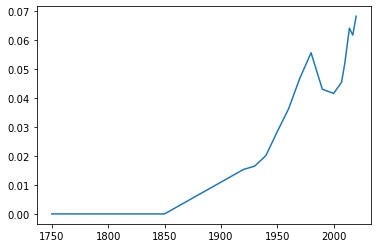

In [24]:
good_models = ['BCC-ESM1', 'CESM2(WACCM6)', 'GFDL-ESM4', 'GISS-E2-1-H', 'MRI-ESM2-0', 'OsloCTM3']
skeie_strat = pd.read_csv('../data/skeie_ozone_strat.csv', index_col=0)
skeie_strat = skeie_strat.loc[good_models]
skeie_strat.insert(0, 1850, 0)
skeie_strat.columns = pd.to_numeric(skeie_strat.columns)
skeie_strat.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
skeie_strat.insert(0, 1750, 0)
skeie_strat_post2010 = skeie_strat.loc['OsloCTM3',[2014,2017,2020]]-skeie_strat.loc['OsloCTM3', 2010]
skeie_strat.loc[:,[2014,2017,2020]] = skeie_strat.loc[:,2010:2010].values + skeie_strat_post2010.values[None,:]
pl.plot(skeie_strat.mean())

In [25]:
f = interp1d(skeie_strat.columns, skeie_strat.mean(), bounds_error=False, fill_value='extrapolate')
years = np.arange(1750,2020)
forcing['o3_strat'] = f(years)

## Stratospheric water vapour

In [26]:
sfh2ostrat = 0.05 / forcing['ch4'][269]
forcing['h2o_strat'] = forcing['ch4'] * sfh2ostrat  # Smith et al., 2018, based on AR5 but scaled for Etminan

Text(0.5, 1.0, 'solar')

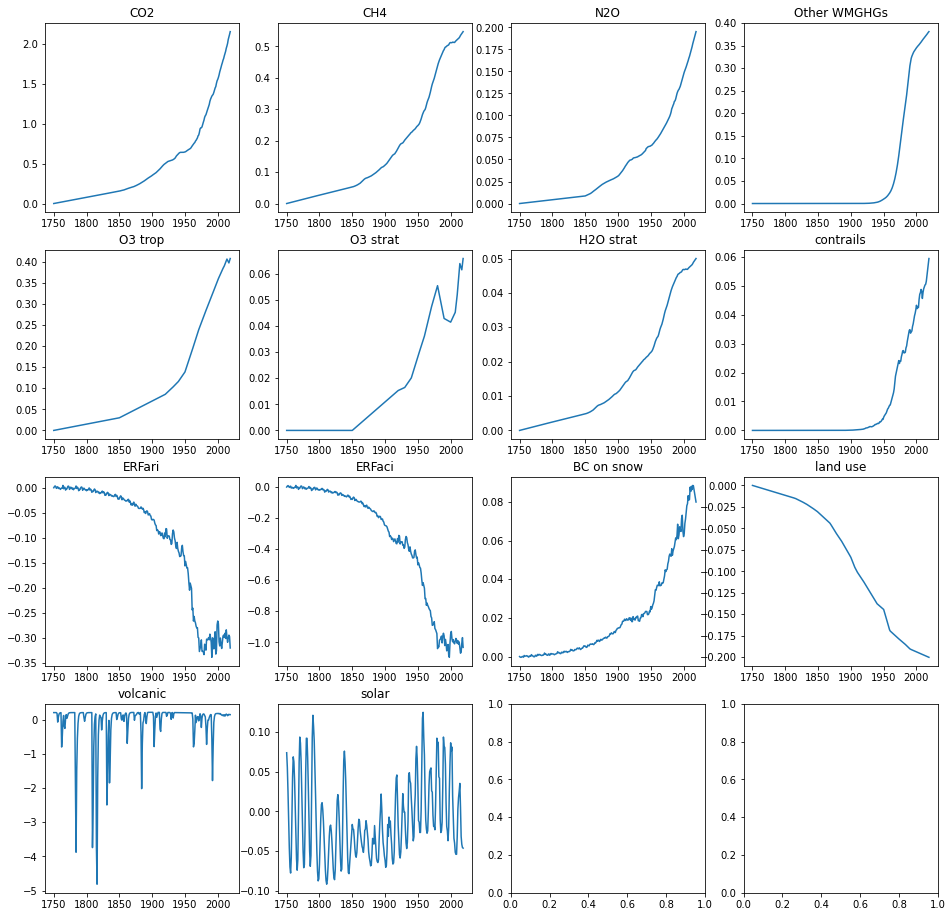

In [27]:
# solar forcing will use the averages of the solar cycles from 1745 to 1765 as the baseline: this is a different treatment to CMIP6
fig, ax = pl.subplots(4,4, figsize=(16,16),squeeze=True)
ax[0,0].plot(np.arange(1750,2020),forcing['co2'])
ax[0,0].set_title('CO2')
ax[0,1].plot(np.arange(1750,2020),forcing['ch4'])
ax[0,1].set_title('CH4')
ax[0,2].plot(np.arange(1750,2020),forcing['n2o'])
ax[0,2].set_title('N2O')
ax[0,3].plot(np.arange(1750,2020),forcing['other_wmghg'])
ax[0,3].set_title('Other WMGHGs')
ax[1,0].plot(np.arange(1750,2020),forcing['o3_trop'])
ax[1,0].set_title('O3 trop')
ax[1,1].plot(np.arange(1750,2020),forcing['o3_strat'])
ax[1,1].set_title('O3 strat')
ax[1,2].plot(np.arange(1750,2020),forcing['h2o_strat'])
ax[1,2].set_title('H2O strat')
ax[1,3].plot(np.arange(1750,2020),forcing['contrails'])
ax[1,3].set_title('contrails')
ax[2,0].plot(np.arange(1750,2020),forcing['aerosol-radiation_interactions'])
ax[2,0].set_title('ERFari')
ax[2,1].plot(np.arange(1750,2020),forcing['aerosol-cloud_interactions'])
ax[2,1].set_title('ERFaci')
ax[2,2].plot(np.arange(1750,2020),forcing['bc_on_snow'])
ax[2,2].set_title('BC on snow')
ax[2,3].plot(np.arange(1750,2020),forcing['land_use'])
ax[2,3].set_title('land use')
ax[3,0].plot(np.arange(1750,2020),forcing['volcanic'])
ax[3,0].set_title('volcanic')
ax[3,1].plot(np.arange(1750,2020),forcing['solar'])
ax[3,1].set_title('solar')

In [28]:
forcing['total_anthropogenic']=forcing['co2']+forcing['ch4']+forcing['n2o']+\
    forcing['other_wmghg']+\
    forcing['o3_trop']+forcing['o3_strat']+forcing['h2o_strat']+forcing['contrails']+\
    forcing['aerosol-radiation_interactions']+forcing['aerosol-cloud_interactions']+forcing['bc_on_snow']+forcing['land_use']
forcing['total_natural']=forcing['volcanic']+forcing['solar']
forcing['total']=forcing['total_anthropogenic']+forcing['total_natural']

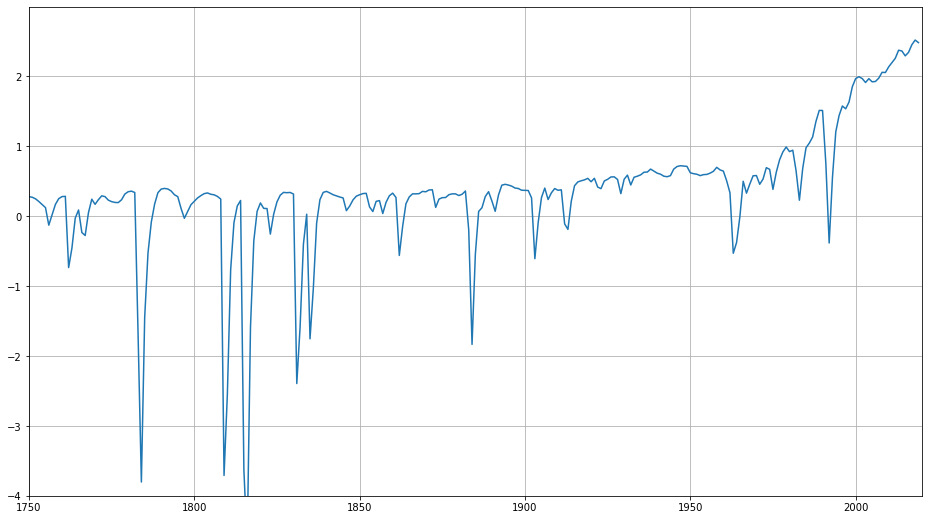

In [29]:
pl.figure(figsize=(16,9))
pl.plot(np.arange(1750,2020), forcing['total'])
pl.yticks(np.arange(-4,3))
pl.xticks(np.arange(1750,2020,50))
pl.ylim(-4,3)
pl.xlim(1750,2020)
pl.grid()

In [30]:
df = pd.DataFrame(data=forcing, index=np.arange(1750,2020))
df.index.name = 'year'
df=df[['co2','ch4','n2o','other_wmghg','o3_trop','o3_strat','h2o_strat','contrails','aerosol-radiation_interactions','aerosol-cloud_interactions','bc_on_snow','land_use',
  'volcanic','solar','total_anthropogenic','total_natural','total']]
df.to_csv('../data/AR6_ERF_1750-2019.csv')
df

,co2,ch4,n2o,other_wmghg,o3_trop,o3_strat,h2o_strat,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.206179,0.073621,0.000000,0.279801,0.279801
1751,0.001571,0.000543,0.000086,7.958010e-10,0.000300,0.000000,0.000050,0.000000,0.002209,0.005929,-0.000288,-0.000229,0.206192,0.055275,0.010172,0.261467,0.271638
1752,0.003142,0.001086,0.000173,1.591602e-09,0.000600,0.000000,0.000099,0.000000,0.003681,0.009285,-0.000388,-0.000458,0.206196,0.025197,0.017220,0.231393,0.248613
1753,0.004712,0.001629,0.000259,2.387403e-09,0.000900,0.000000,0.000149,0.000000,0.002243,0.006050,-0.000299,-0.000687,0.206197,-0.010981,0.014957,0.195217,0.210173
1754,0.006282,0.002171,0.000346,3.183204e-09,0.001200,0.000000,0.000198,0.000000,-0.001228,-0.002428,0.000018,-0.000916,0.206198,-0.045395,0.005643,0.160802,0.166446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,2.001776,0.535137,0.184062,3.732417e-01,0.404167,0.063233,0.048900,0.051491,-0.308151,-1.069865,0.088397,-0.198663,0.115851,0.005228,2.173724,0.121080,2.294804
2016,2.050532,0.538162,0.186453,3.751911e-01,0.401100,0.062433,0.049177,0.053461,-0.299538,-1.061876,0.086297,-0.198998,0.133391,-0.031556,2.242395,0.101835,2.344229
2017,2.080581,0.540854,0.189147,3.774247e-01,0.398033,0.061633,0.049423,0.055430,-0.293984,-1.005474,0.084198,-0.199332,0.156815,-0.041435,2.337936,0.115379,2.453315


In [31]:
df.loc[2000:2020]

,co2,ch4,n2o,other_wmghg,o3_trop,o3_strat,h2o_strat,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,,
2000,1.552699,0.512465,0.146780,0.345242,0.357217,0.041550,0.046829,0.043223,-0.265807,-0.947134,0.062096,-0.193651,0.181311,0.086039,1.701506,0.267351,1.968857
2001,1.576555,0.511833,0.149065,0.347165,0.360762,0.042090,0.046771,0.042065,-0.271204,-0.929865,0.063653,-0.193985,0.176051,0.075478,1.744905,0.251529,1.996433
2002,1.606972,0.512160,0.151034,0.348908,0.364307,0.042631,0.046801,0.042602,-0.307307,-0.976524,0.068921,-0.194319,0.182835,0.080766,1.706185,0.263601,1.969786
2003,1.645201,0.513707,0.153176,0.350486,0.367852,0.043171,0.046942,0.042423,-0.315495,-0.996651,0.071183,-0.194654,0.166479,0.019394,1.727342,0.185873,1.913215
2004,1.672599,0.513494,0.155169,0.352206,0.371398,0.043712,0.046923,0.045225,-0.299675,-0.982495,0.074668,-0.194988,0.177394,-0.007392,1.798234,0.170002,1.968236
2005,1.702703,0.512675,0.157336,0.354011,0.374943,0.044252,0.046848,0.047028,-0.311845,-1.003584,0.078116,-0.195322,0.149669,-0.033851,1.807163,0.115817,1.922981
2006,1.734291,0.512722,0.159892,0.355778,0.378488,0.044793,0.046852,0.047588,-0.320597,-1.009594,0.079107,-0.195656,0.134563,-0.039857,1.833665,0.094706,1.928371
2007,1.759977,0.515327,0.162141,0.357848,0.382033,0.045333,0.047090,0.048698,-0.307414,-0.992084,0.083265,-0.195990,0.120955,-0.051371,1.906226,0.069585,1.975811
2008,1.790986,0.517825,0.164860,0.360018,0.385033,0.047567,0.047319,0.048107,-0.296083,-0.974904,0.081033,-0.196324,0.137495,-0.053851,1.975437,0.083644,2.059081
